In [1]:
import warnings
from tqdm import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# concat the files based on the subject sequence number
# forward fills the whole df, then keeps the last row which contains every available data point
relevants = ['BPX', 'BMX', 'DEMO', 'BPQ', 'DIQ', 'SMQ', 'ALQ', 'PAQ']
files = os.listdir('download')
files = [f for f in files if f.lower().endswith('.xpt')] # to remove files such as .DS_Store
files.remove('PAQ_L.xpt') # this one has string literals and i couldn't find the docs for it 
dfs = [pd.read_sas('download/' + file) for file in files]
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values('SEQN')

# directly applying ffill drops the seqn column
# but using apply() and a lambda expression takes too long, this is a workaround
seqn = df['SEQN']
df = df.groupby('SEQN', as_index=False).ffill()
df.insert(loc=0, column='SEQN', value=seqn)
df = df.drop_duplicates(subset='SEQN', keep='last')

In [3]:
bp_columns = ["BPXSY1", "BPXSY2", "BPXSY3", "BPXDI1", "BPXDI2", "BPXDI3"]

print(f"Remaining rows before cleaning: {df.shape[0]}")

df["Systolic Average"] = df[["BPXSY1", "BPXSY2", "BPXSY3"]].mean(axis=1, skipna=True)
df["Diastolic Average"] = df[["BPXDI1", "BPXDI2", "BPXDI3"]].mean(axis=1, skipna=True)

df.drop(columns=bp_columns, inplace=True)

# remove rows nan values
df = df.dropna(subset=["Systolic Average", "Diastolic Average"])


# remove outliers
sys_lower, sys_upper = 50, 250  
dia_lower, dia_upper = 50, 150  

df = df[
    (df["Systolic Average"].between(sys_lower, sys_upper)) &
    (df["Diastolic Average"].between(dia_lower, dia_upper))
]

print(f"Remaining rows after cleaning: {df.shape[0]}")

Remaining rows before cleaning: 103284
Remaining rows after cleaning: 59292


In [4]:
# create label column
label_names = {'HYPERTENSIVE':1, 'NORMAL':0}
df['label'] = np.where((df["Systolic Average"] >= 130) | (df["Diastolic Average"] >= 80), 
                       label_names['HYPERTENSIVE'], 
                       label_names['NORMAL'])

# remove additional columns that have explicit bp information
extra_bp_cols = [
    "BPXSAR", "BPXDAR", "BPACSZ", "BPXML1",  # bp measurement process+readings
    "BPQ020", "BPQ030", "BPQ040A", "BPQ050A",  # self reported bp history
    "BPQ060", "BPQ070", "BPQ090D", "BPQ100D", "BPQ057", "BPQ056", "BPQ059", "BPQ010",  # explicit hypertension indicators
    "BPQ080", "BPD035",  # these're not really explicit but i'm dropping these too for consistency
    "BPQ150A", "BPQ150B", "BPQ150C", "BPQ150D",  # explicit bp medication history
    "BPXPLS", "BPXPULS", "BPXPTY",  # pulse and bp-related readings
    "BPAARM", "BPAEN1", "BPAEN2", "BPAEN3"  # bp measurement process artifacts
]

df.drop(columns=extra_bp_cols, inplace=True)

## Preliminary Data Analysis

### Missingness

For identifying key features, I will compare each measured metric (which i will refer as a column moving forward) of each file with different methods but the data contains lots of NaN values, and it'd be unnecessary to analyze a column that has 99% NaN values. So we'll start by checking the percentage of NaN values of a column, to see that how frequent that value is missing. And we'll see how much of the data we're eliminating by comparing different thresholds for this NaN percentage.

We could also check the total NaN percentage of a file and eliminate the files with too many NaNs, which would be more straightforward, but I want to leave as much as data as possible for training so I'll try to salvage columns with tolerable NaN values.

In [5]:
def nanPercentage(df):
    # calculate nan percents for each col in df
    nan_percents = (df.isna().mean() * 100).reset_index()
    nan_percents.columns = ['col', 'nan_percent']
    return nan_percents

def thrCols(target_df, target_col, thr=98, reverse=False):
    # return cols that have nan/corr percentages under a threshold
    return target_df[target_df[target_col] > thr] if reverse else target_df[target_df[target_col] <= thr]


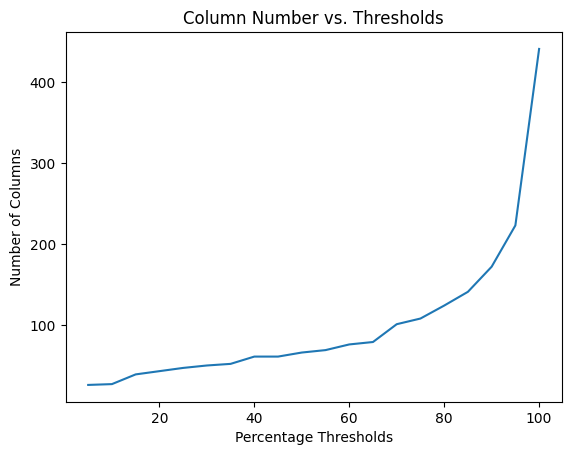

In [6]:
nans = nanPercentage(df)
thresholds = range(100, 0, -5)
col_n = [thrCols(nans, 'nan_percent',thr).shape[0] for thr in thresholds] 

plt.plot(thresholds, col_n)

plt.xlabel("Percentage Thresholds")
plt.ylabel("Number of Columns")
plt.title("Column Number vs. Thresholds")
plt.show()

The graph above shows that choosing a low percentage of NaN values reduces the amount of data we have drastically. Hence, I'll choose a percentage threshold of 85 (i'll test other threshold values if i have the time) and fill-in the missing NaN values when preparing the dataset.

Now I'll check for missingness patterns if there're any that could be useful for further elimination.

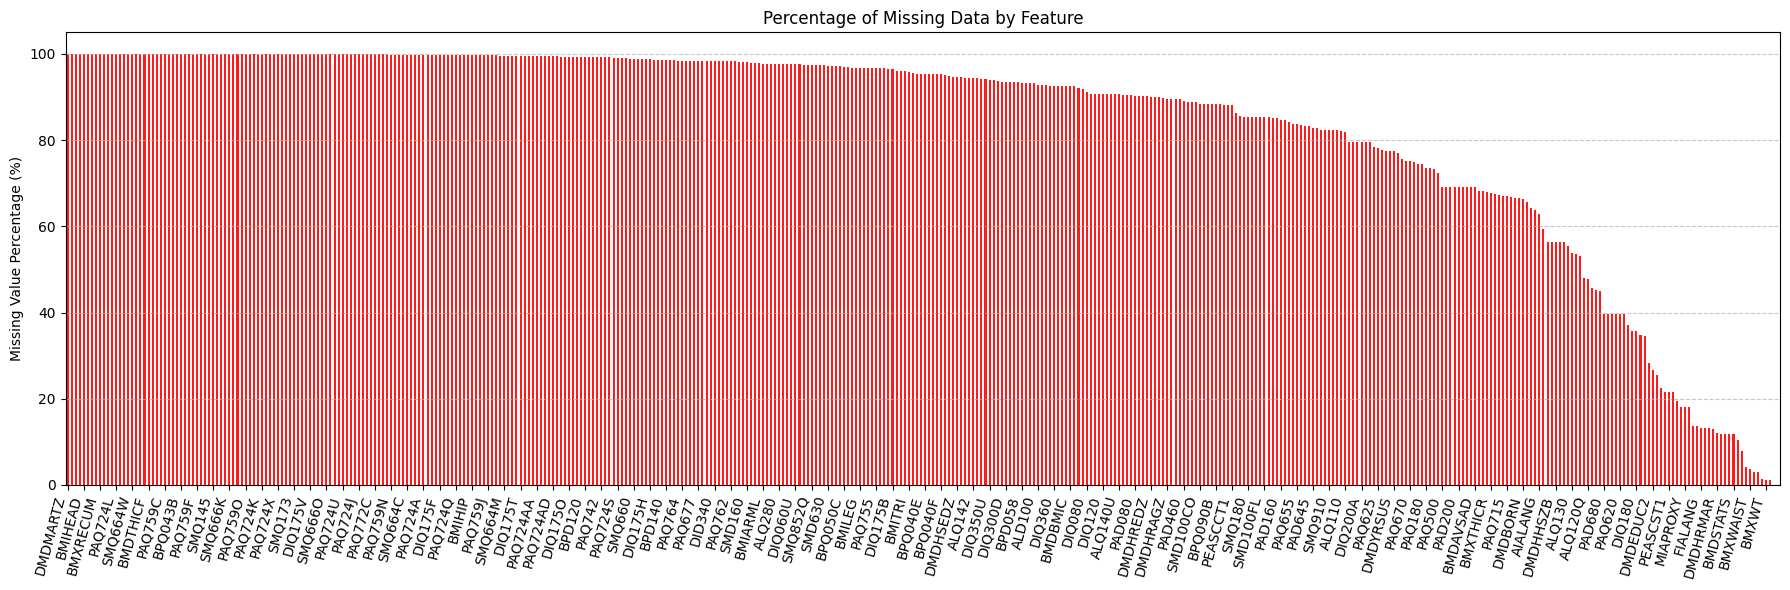

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# calculate missing value percentages
missing_data = df.isnull().mean() * 100
missing_data = missing_data[missing_data > 0] 
missing_data.sort_values(ascending=False, inplace=True)

# plot missing value percentages
plt.figure(figsize=(18, 6))
ax = missing_data.plot(kind='bar', color='red', alpha=0.9)

# formatting improvements
plt.ylabel("Missing Value Percentage (%)")
plt.title("Percentage of Missing Data by Feature")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# show only every nth label
n = 4 
ax.set_xticks(np.arange(len(missing_data))[::n])
ax.set_xticklabels(missing_data.index[::n], rotation=75, ha='right')

plt.tight_layout()
plt.show()

In [8]:
missing_percent = df.isna().mean() * 100
missing_percent_sorted = missing_percent.sort_values(ascending=False)

with open("missingness_sorted.txt", "w") as f:
    f.write(missing_percent_sorted.to_string())

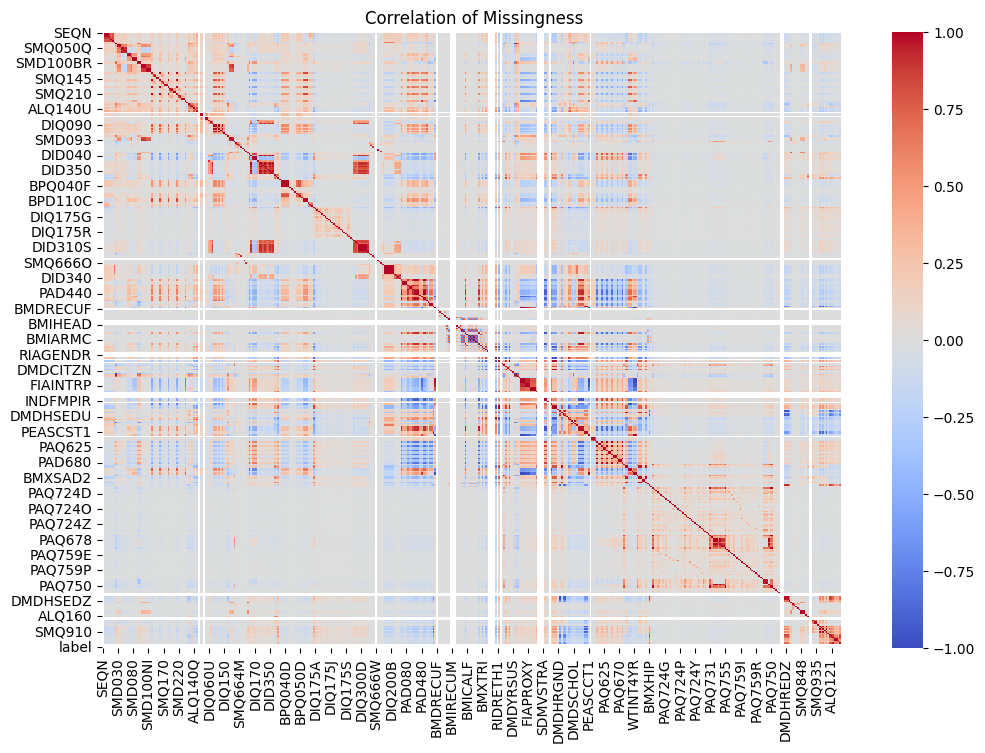

In [9]:
missing_corr = df.isna().corr()
plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, cmap="coolwarm", annot=False)
plt.title("Correlation of Missingness")
plt.show()

It seems like there're aren't any major revelations that couldn't be found on the variable explanation page of the NHANES. Feel free to check it out.
https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx

In [10]:
# proceed by dropping the mostly-nan columns
print(f"Remaining columns before dropping: {df.shape[1]}")
df = df.drop(thrCols(nans, 'nan_percent', thr=85, reverse = True)['col'], axis=1)
print(f"Remaining columns after dropping: {df.shape[1]}")

Remaining columns before dropping: 441
Remaining columns after dropping: 141


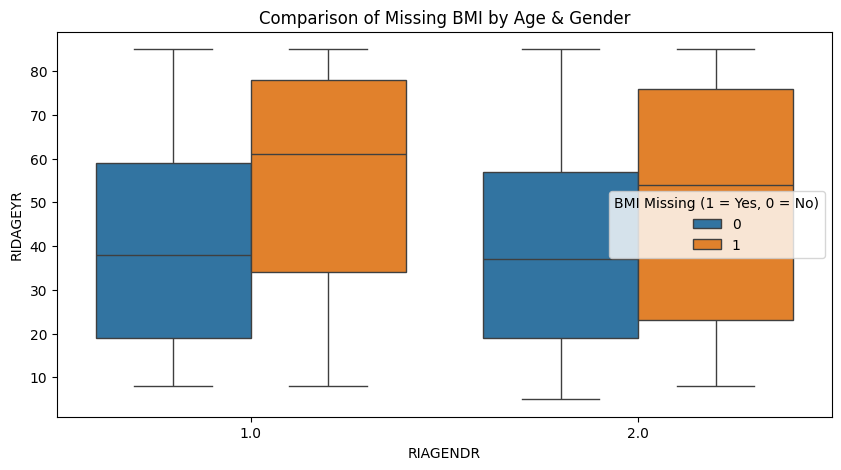

In [11]:
# bmi seems to be missing more commonly for older participants
df['BMI_missing'] = df['BMXBMI'].isnull().astype(int)

plt.figure(figsize=(10, 5))
sns.boxplot(x='RIAGENDR', y='RIDAGEYR', hue='BMI_missing', data=df)
plt.title("Comparison of Missing BMI by Age & Gender")
plt.legend(title="BMI Missing (1 = Yes, 0 = No)")
plt.show()

In [12]:
def corPercentage(df):
    # calculate a correlation matrix based on bpx
    corr_matrix = df.corr()[['Diastolic Average', 'Systolic Average']].multiply(100).reset_index()
    corr_matrix.columns = ['col'] + ['Diastolic Average', 'Systolic Average']
    return corr_matrix

def returnSigCols(corr_matrix, thr=98):
    # return the significant columns of a dataframe
    # if the column has high correlation with any of the bpx values
    sig_cols = []
    unsig_cols = []
    for col in corr_matrix['col']:
        target_row = ((corr_matrix.loc[corr_matrix['col'] == col]).drop(columns=['col']))
        if any(abs(x) > thr for x in target_row.iloc[0]):
            sig_cols.append(col)
        else:
            # these will be dropped from the dataframe
            unsig_cols.append(col)
    return (sig_cols, unsig_cols)

In [13]:
# before calculating the correlations we should deal with string values in the df
# there're two columns which have string values: SMDUPCA and SMD100BR
# the first one is the cigarette product code, which we can drop
# and we'll encode the latter column with a basic scheme
# but depending on the nan percentage chosen they might be dropped, so a check first
if 'SMD100BR' in df.columns:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df['SMD100BR'] = le.fit_transform(df['SMD100BR'])
if 'SMDUPCA' in df.columns:
    df = df.drop(columns='SMDUPCA')

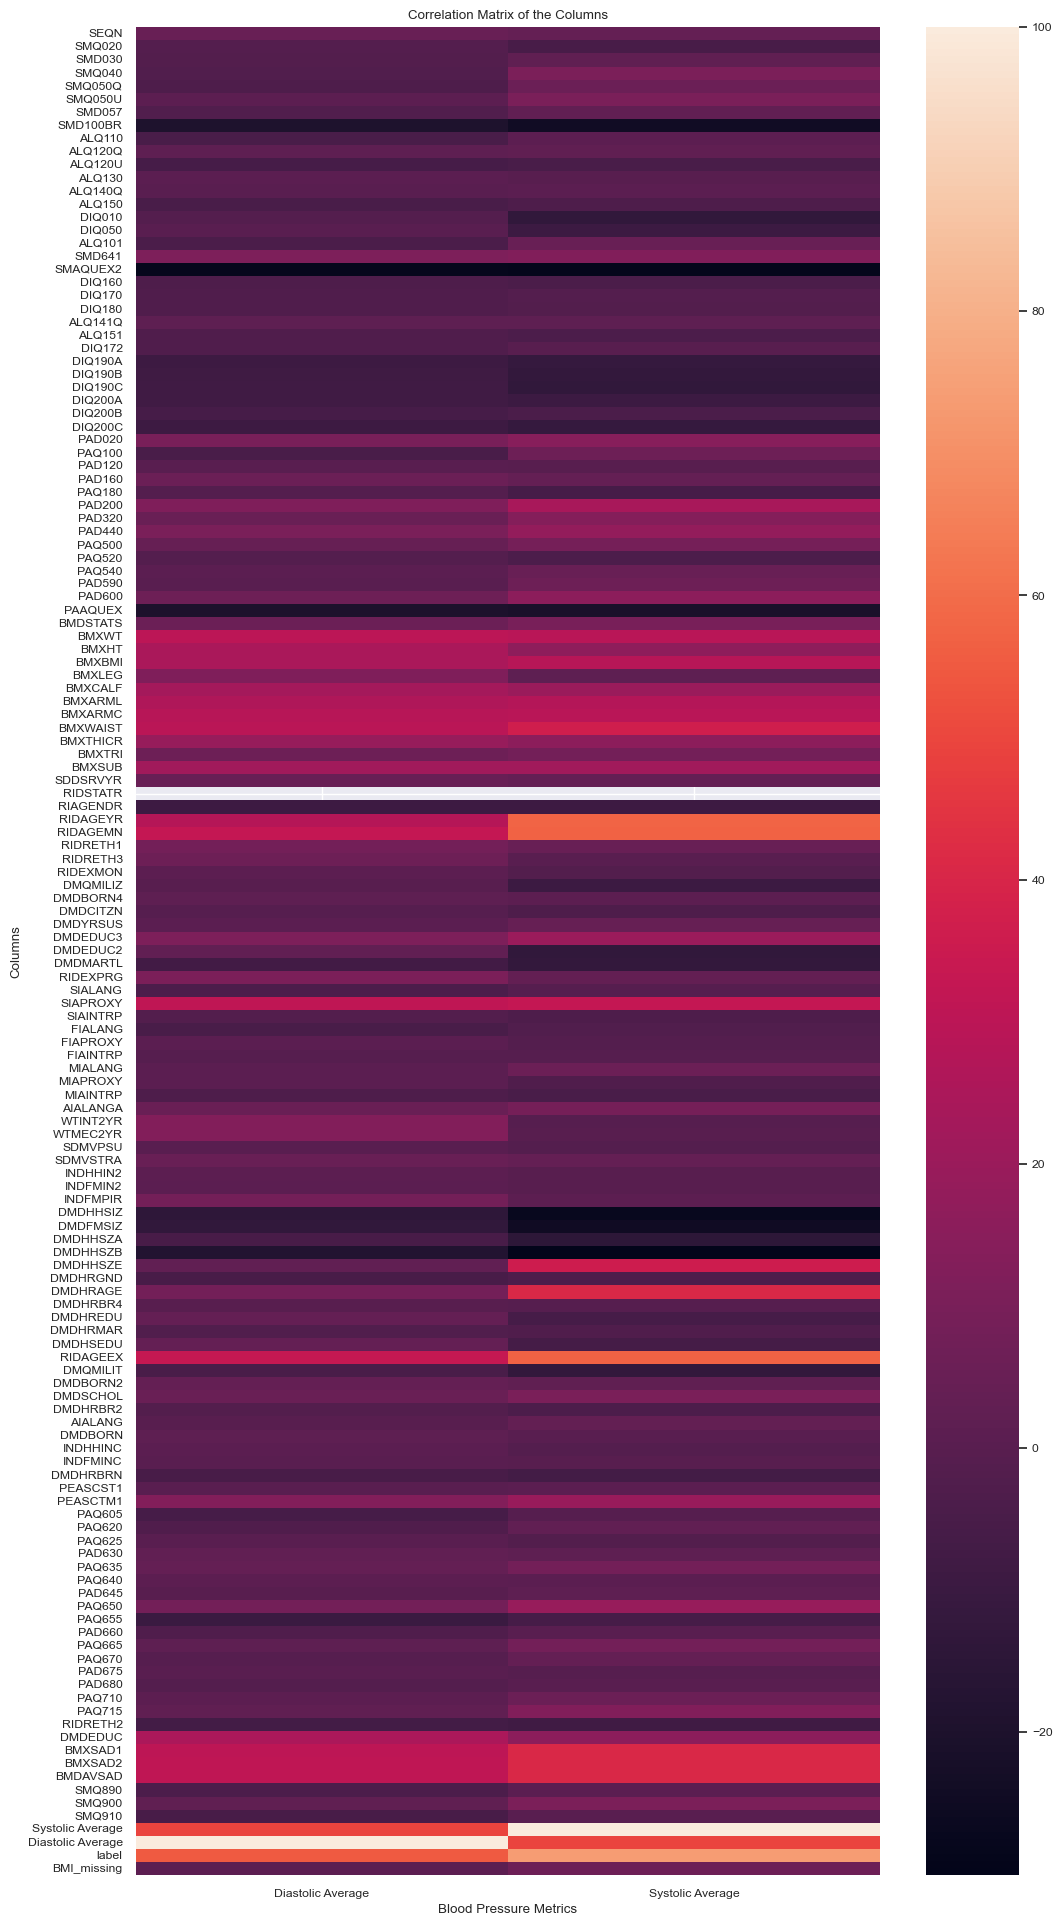

In [14]:
corr_matrix_sig = corPercentage(df)
plt.figure(figsize=(12, 24))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix_sig.drop(columns=['col']), yticklabels=corr_matrix_sig['col'])
plt.xlabel("Blood Pressure Metrics")
plt.ylabel("Columns")
plt.title("Correlation Matrix of the Columns")
plt.show()

## Preprocessing

Now that we've chosen our columns we'll do the preprocessing on, we can start by fixing the NaN values. For this there are several imputation methods and I'll start by trying out K-NN Imputer, and switch to another one if the performance is subpar.

Based on the value description from the CDC site, there're also some manual cleaning I could do on the values since there're certain rules between them. But due to time constraints I'll consider that option if imputation doesn't yield any good results.

In [15]:
# some basic encoding for categorical variables
from sklearn.preprocessing import LabelEncoder

# binary categorical variables (yes/no → 0/1)
binary_vars = [
    "SMQ020", "DIQ010", "DIQ050", "DIQ160", "ALQ110", 
    "SIALANG", "SIAPROXY", "SIAINTRP", "FIAPROXY", "FIAINTRP", 
    "MIAPROXY", "MIAINTRP", "DMQMILIZ", "DMDBORN4", "DMDCITZN"
]

for col in binary_vars:
    if col in df.columns:
        df[col] = df[col].map({1: 1, 2: 0})

# ordinal encoding
multi_cat_vars = [
    "RIAGENDR", "RIDRETH1", "RIDRETH3", "DMDEDUC2", "DMDMARTL", 
    "RIDEXPRG", "DMDHRMAR", "DMDHREDU", "DMDBORN"
]

for col in multi_cat_vars:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

In [16]:
from sklearn.impute import KNNImputer

#knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
#df[:] = knn_imputer.fit_transform(df)

# writing
#df.to_csv('imputed.csv', index=False)

# reading
df = pd.read_csv('imputed.csv', index_col=0)

## Visualizations

/var/folders/2q/0wssj_m1199_8dn42_d3j9lh0000gn/T/ipykernel_33025/1648744539.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="pastel", ax=ax1)


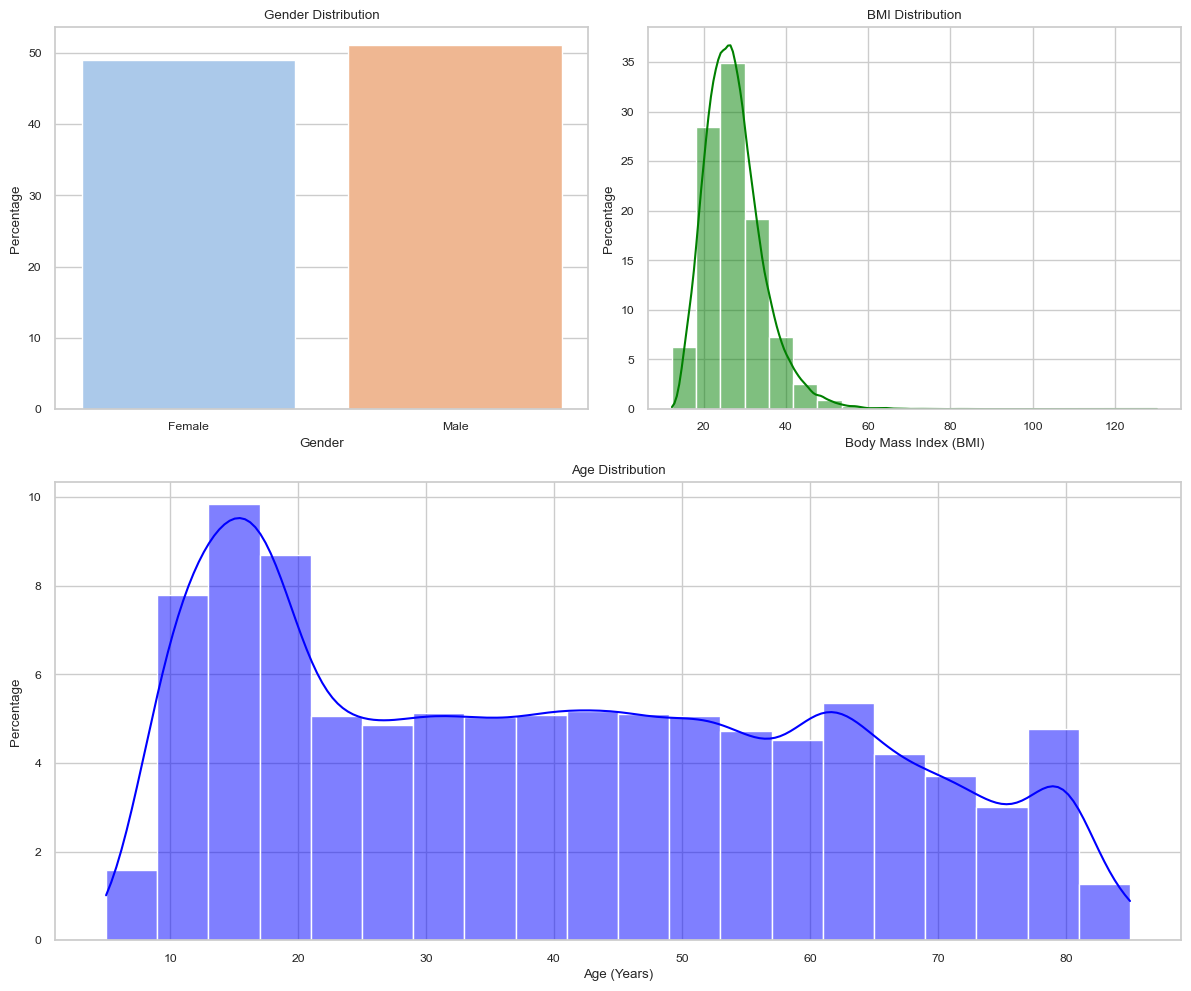

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec 

sns.set_style("whitegrid")

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2]) 

ax1 = plt.subplot(gs[0, 0])
gender_counts = df["RIAGENDR"].value_counts(normalize=True) * 100
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="pastel", ax=ax1)
ax1.set_title("Gender Distribution")
ax1.set_xlabel("Gender")
ax1.set_ylabel("Percentage")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["Female", "Male"])

ax2 = plt.subplot(gs[0, 1])
sns.histplot(df["BMXBMI"], bins=20, kde=True, color="green", stat="percent", ax=ax2)
ax2.set_title("BMI Distribution")
ax2.set_xlabel("Body Mass Index (BMI)")
ax2.set_ylabel("Percentage")

ax3 = plt.subplot(gs[1, :])  # This spans both columns
sns.histplot(df["RIDAGEYR"], bins=20, kde=True, color="blue", stat="percent", ax=ax3)
ax3.set_title("Age Distribution")
ax3.set_xlabel("Age (Years)")
ax3.set_ylabel("Percentage")

plt.tight_layout()
plt.show()

/var/folders/2q/0wssj_m1199_8dn42_d3j9lh0000gn/T/ipykernel_33025/519748319.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="RIDAGEYR", data=df, palette="coolwarm", ax=axes[0, 0])
/var/folders/2q/0wssj_m1199_8dn42_d3j9lh0000gn/T/ipykernel_33025/519748319.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="BMXBMI", data=df, palette="coolwarm", ax=axes[0, 1])
/var/folders/2q/0wssj_m1199_8dn42_d3j9lh0000gn/T/ipykernel_33025/519748319.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(["Age (Years)", "BMI"])


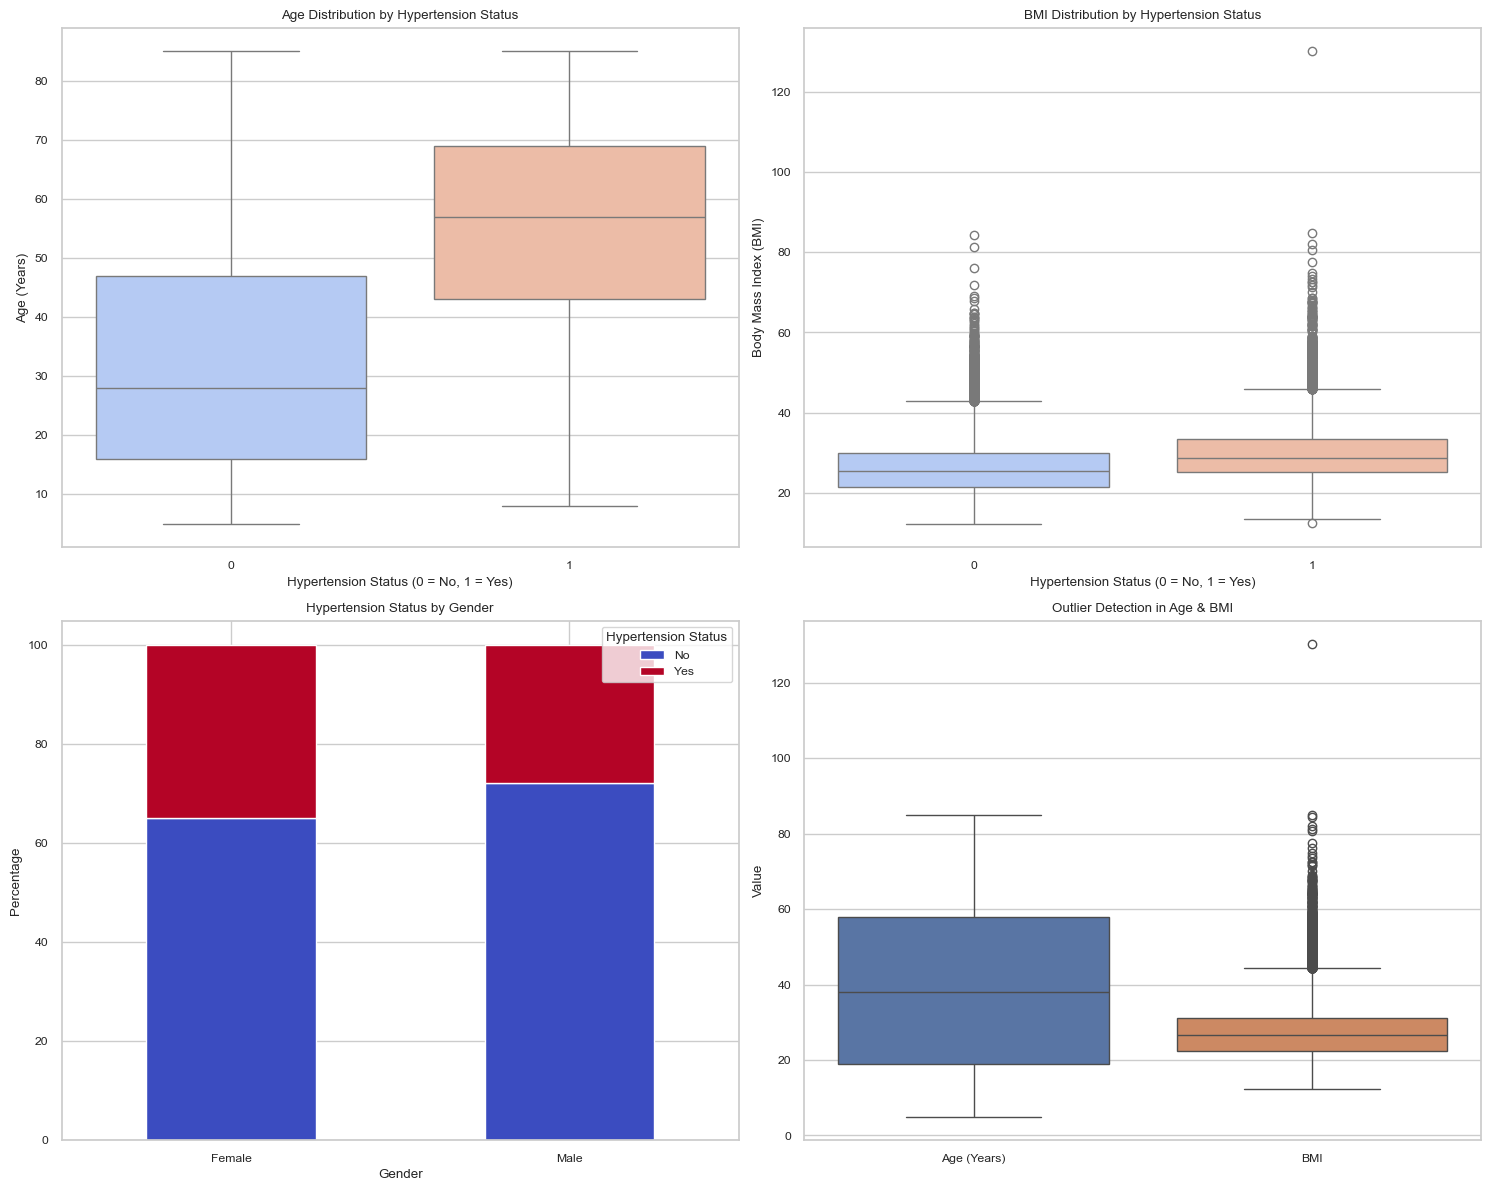

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.boxplot(x="label", y="RIDAGEYR", data=df, palette="coolwarm", ax=axes[0, 0])
axes[0, 0].set_title("Age Distribution by Hypertension Status")
axes[0, 0].set_xlabel("Hypertension Status (0 = No, 1 = Yes)")
axes[0, 0].set_ylabel("Age (Years)")

sns.boxplot(x="label", y="BMXBMI", data=df, palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("BMI Distribution by Hypertension Status")
axes[0, 1].set_xlabel("Hypertension Status (0 = No, 1 = Yes)")
axes[0, 1].set_ylabel("Body Mass Index (BMI)")

gender_hypertension_counts = df.groupby("RIAGENDR")["label"].value_counts(normalize=True).unstack() * 100
gender_hypertension_counts.plot(kind="bar", stacked=True, colormap="coolwarm", ax=axes[1, 0])
axes[1, 0].set_title("Hypertension Status by Gender")
axes[1, 0].set_xlabel("Gender")
axes[1, 0].set_ylabel("Percentage")
axes[1, 0].legend(title="Hypertension Status", labels=["No", "Yes"], loc="upper right")
axes[1, 0].set_xticklabels(["Female", "Male"], rotation=0)

sns.boxplot(data=df[["RIDAGEYR", "BMXBMI"]], ax=axes[1, 1])
axes[1, 1].set_title("Outlier Detection in Age & BMI")
axes[1, 1].set_ylabel("Value")
axes[1, 1].set_xticklabels(["Age (Years)", "BMI"])

plt.tight_layout()
plt.show()

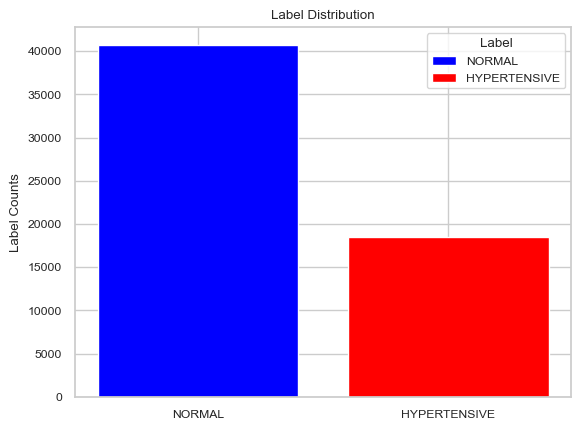

In [19]:
# major class difference
label_counts = df['label'].value_counts()

fig, ax = plt.subplots()
ax.bar(list(label_names.keys())[::-1], label_counts, label=list(label_names.keys())[::-1], color=['blue', 'red'])

ax.set_ylabel('Label Counts')
ax.set_title('Label Distribution')
ax.legend(title='Label')

plt.show()

## Class Imbalances

In [20]:
print(label_names)
print(df["label"].value_counts(normalize=True) * 100)

{'HYPERTENSIVE': 1, 'NORMAL': 0}
label
0    68.72934
1    31.27066
Name: proportion, dtype: float64


In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=447)

X = df.drop(columns=["label"])
y = df["label"]

X_resampled, y_resampled = smote.fit_resample(X, y)
df_balanced = X_resampled.assign(label=y_resampled)

print(df_balanced["label"].value_counts(normalize=True) * 100)

label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [22]:
#df_balanced.to_csv('balanced.csv', index=False)